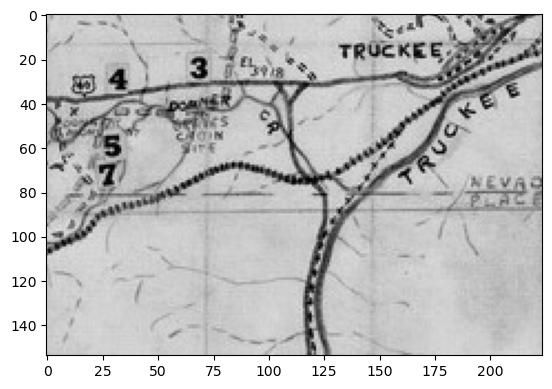

In [1]:
# For H1 inpainting, run cells [1-3].
# For TV inpainting, run cells [1-2] and [4].
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as im
import timeit
from skimage import color
from PIL import Image, ImageOps
f = im.imread("Final Map.png", as_gray=True) # "Final Small Stain.png" OR "Final Map.png"
f0 = im.imread("Cropped Map.jpg", as_gray=True) # "Original Small Stain.jpg" OR "Cropped Map.jpg"
plt.imshow(f0,cmap='gray', vmin=0, vmax=255)
# plt.savefig('Test Image.png')

Tolerance = 0.29092478648104886


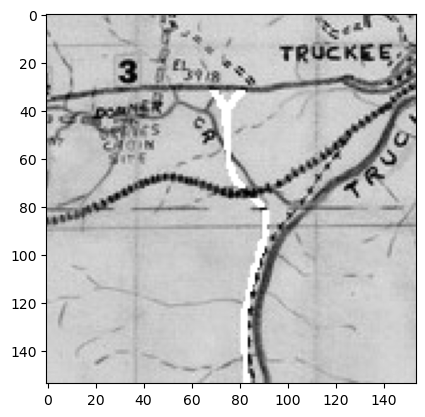

In [2]:
# Parameters
size = 154 # Change size to 168/154 for Stain/Map.
fnormsquared = 0
for i in range(0,size):
    for j in range(0,size):
        fnormsquared = fnormsquared + f[i,j]**2
fnorm = np.sqrt(fnormsquared)
Tolerance = fnorm/(10**5)
gamma = 5
lam = 1 # TWEAK THIS?
# Initialization
u = np.zeros((size,size))
G = np.zeros((size,size))
uprev = np.zeros((size,size))
ugrad = np.zeros((size,size,2))
b = np.zeros((size,size,2))
d = np.zeros((size,size,2))
# Region D
D = np.ones((size,size))
for i in range(0,size):
    for j in range(0,size):
        if f[i,j] < 245: # Change to black/white for Stain/Map.
            D[i,j] = 0
        u[i,j] = f[i,j]
print('Tolerance =',Tolerance)
plt.imshow(u,cmap='gray', vmin=0, vmax=255)

In [ ]:
# 0-index gives height.
# 1-index gives length.
# Laplace Equation Inpainting
start = timeit.default_timer()
Iterations = 0
normsquared = 0
for i in range(0,size):
    for j in range(0,size):
        normsquared = normsquared + (u[i,j]-uprev[i,j])**2
norm = np.sqrt(normsquared)
while norm > Tolerance:
    Iterations = Iterations + 1
    for i in range(0,size):
        for j in range(0,size):    
            uprev[i,j] = u[i,j]
    for i in range(1,size-1):
        for j in range(1,size-1):
            if D[i,j] == 1:
                G[i,j] = (1/4)*(u[i+1,j]+u[i-1,j]+u[i,j+1]+u[i,j-1])
    for i in range(1,size-1):
        if D[i,0] == 1:
            G[i,0] = (1/3)*(u[i+1,0]+u[i-1,0]+u[i,1])
        if D[i,size-1] == 1:
            G[i,size-1] = (1/3)*(u[i+1,size-1]+u[i-1,size-1]+u[i,size-2])
    for j in range(1,size-1):
        if D[0,j] == 1:
            G[0,j] = (1/3)*(u[1,j]+u[0,j+1]+u[0,j-1])
        if D[size-1,j] == 1:
            G[size-1,j] = (1/3)*(u[size-2,j]+u[size-1,j+1]+u[size-1,j-1])
    if D[0,0] == 1:
        G[0,0] = (1/2)*(u[1,0]+u[0,1])
    if D[0,size-1] == 1:
        G[0,size-1] = (1/2)*(u[1,size-1]+u[0,size-2])
    if D[size-1,0] == 1:
        G[size-1,0] = (1/2)*(u[size-2,0]+u[size-1,1])
    if D[size-1,size-1] == 1:
        G[size-1,size-1] = (1/2)*(u[size-2,size-1]+u[size-1,size-2])
    for i in range(0,size):
        for j in range(0,size):
            if D[i,j] == 1:
                u[i,j] = G[i,j]
    normsquared = 0
    for i in range(0,size):
        for j in range(0,size):
            normsquared = normsquared + (u[i,j]-uprev[i,j])**2
    norm = np.sqrt(normsquared)
stop = timeit.default_timer()
print('Iterations =',Iterations)
print('Runtime =',stop-start)
plt.imshow(u,cmap='gray', vmin=0, vmax=255)

Runtime = 9.465077799977735


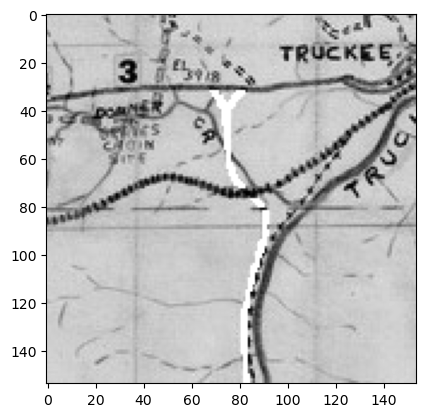

In [3]:
# 0-index gives height.
# 1-index gives length.
# Total Variation Inpainting
start2 = timeit.default_timer()
for loop in range(51): # Change to 51 for map and 467 for stain.
    for i in range(0,size-1):
        for j in range(0,size-1):
            ugrad[i,j,0] = u[i+1,j] - u[i,j]
            ugrad[i,j,1] = u[i,j+1] - u[i,j]
    for i in range(0,size-1):
        ugrad[i,size-1,0] = u[i+1,j] - u[i,j]
        ugrad[i,size-1,1] = 0
    for j in range(0,size-1):
        ugrad[size-1,j,0] = 0
        ugrad[size-1,j,1] = u[i,j+1] - u[i,j]
    ugrad[size-1,size-1,0] = 0
    ugrad[size-1,size-1,1] = 0
    # h Subproblem
    for i in range(0,size):
        for j in range(0,size):
            vecmag = np.absolute(np.sqrt(((ugrad[i,j,0]+b[i,j,0])**2)+((ugrad[i,j,1]+b[i,j,1])**2)))
            if vecmag > 1:
                d[i,j,0] = (ugrad[i,j,0]+b[i,j,0]) - ((1/gamma)/vecmag)
                d[i,j,1] = (ugrad[i,j,1]+b[i,j,1]) - ((1/gamma)/vecmag)
            else:
                d[i,j,0] = 0
                d[i,j,1] = 0
    # u Subproblem
    for i in range(1,size-1):
        for j in range(1,size-1):
            # if D[i,j] == 1:
            #     G[i,j] = (1/4)*(u[i+1,j]+u[i-1,j]+u[i,j+1]+u[i,j-1]+d[i-1,j,0]-d[i,j,0]+d[i,j-1,1]-d[i,j,1]-b[i-1,j,0]+b[i,j,0]-b[i,j-1,1]+b[i,j,1])
            # else:
            #     G[i,j] = (gamma/(lam+4*gamma))*(u[i+1,j]+u[i-1,j]+u[i,j+1]+u[i,j-1]+d[i-1,j,0]-d[i,j,0]+d[i,j-1,1]-d[i,j,1]-b[i-1,j,0]+b[i,j,0]-b[i,j-1,1]+b[i,j,1])+(lam/(lam+4*gamma))*f[i,j]
            if D[i,j] == 1:
                G[i,j] = (gamma/(lam+4*gamma))*(u[i+1,j]+u[i-1,j]+u[i,j+1]+u[i,j-1]+d[i-1,j,0]-d[i,j,0]+d[i,j-1,1]-d[i,j,1]-b[i-1,j,0]+b[i,j,0]-b[i,j-1,1]+b[i,j,1])+(lam/(lam+4*gamma))*f[i,j]
    for i in range(1,size-1):
        if D[i,0] == 1:
            G[i,0] = (gamma/(lam+3*gamma))*(u[i+1,j]+u[i-1,j]+u[i,j+1]+d[i-1,j,0]-d[i,j,0]-d[i,j,1]-b[i-1,j,0]+b[i,j,0]+b[i,j,1])+(lam/(lam+3*gamma))*f[i,j]
        if D[i,size-1] == 1:
            G[i,size-1] = (gamma/(lam+3*gamma))*(u[i+1,j]+u[i-1,j]+u[i,j-1]+d[i-1,j,0]-d[i,j,0]+d[i,j-1,1]-d[i,j,1]-b[i-1,j,0]+b[i,j,0]-b[i,j-1,1]+b[i,j,1])+(lam/(lam+3*gamma))*f[i,j]
    for j in range(1,size-1):
        if D[0,j] == 1:
            G[0,j] = (gamma/(lam+3*gamma))*(u[i+1,j]+u[i,j+1]+u[i,j-1]-d[i,j,0]+d[i,j-1,1]-d[i,j,1]+b[i,j,0]-b[i,j-1,1]+b[i,j,1])+(lam/(lam+3*gamma))*f[i,j]
        if D[size-1,j] == 1:
            G[size-1,j] = (gamma/(lam+3*gamma))*(u[i-1,j]+u[i,j+1]+u[i,j-1]+d[i-1,j,0]-d[i,j,0]+d[i,j-1,1]-d[i,j,1]-b[i-1,j,0]+b[i,j,0]-b[i,j-1,1]+b[i,j,1])+(lam/(lam+3*gamma))*f[i,j]
    if D[0,0] == 1:
        G[0,0] = (gamma/(lam+2*gamma))*(u[i+1,j]+u[i,j+1]-d[i,j,0]-d[i,j,1]+b[i,j,0]+b[i,j,1])+(lam/(lam+2*gamma))*f[i,j]
    if D[0,size-1] == 1:
        G[0,size-1] = (gamma/(lam+2*gamma))*(u[i+1,j]+u[i,j-1]-d[i,j,0]+d[i,j-1,1]-d[i,j,1]+b[i,j,0]-b[i,j-1,1]+b[i,j,1])+(lam/(lam+2*gamma))*f[i,j]
    if D[size-1,0] == 1:
        G[size-1,0] = (gamma/(lam+2*gamma))*(u[i-1,j]+u[i,j+1]+d[i-1,j,0]-d[i,j,0]-d[i,j,1]-b[i-1,j,0]+b[i,j,0]+b[i,j,1])+(lam/(lam+2*gamma))*f[i,j]
    if D[size-1,size-1] == 1:
        G[size-1,size-1] = (gamma/(lam+2*gamma))*(u[i-1,j]+u[i,j-1]+d[i-1,j,0]-d[i,j,0]+d[i,j-1,1]-d[i,j,1]-b[i-1,j,0]+b[i,j,0]-b[i,j-1,1]+b[i,j,1])+(lam/(lam+2*gamma))*f[i,j]
    for i in range(1,size-1):
        for j in range(1,size-1):
            if D[i,j] == 1:
                u[i,j] = G[i,j]
    # b Subproblem
    for i in range(0,size):
        for j in range(0,size):
            b[i,j,0] = b[i,j,0] + ugrad[i,j,0] - d[i,j,0]
            b[i,j,1] = b[i,j,1] + ugrad[i,j,1] - d[i,j,1]
stop2 = timeit.default_timer()
print('Runtime =',stop2-start2)
plt.imshow(u,cmap='gray', vmin=0, vmax=255)